Energy estimation using Random Forest Regression with or w/o using sample weights on events while training.

In [2]:
import glob
import numpy
import sys, os
import tables
from scipy.optimize import curve_fit
import pyunfold

import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
%matplotlib inline

sys.path.append('/Users/ramesh/GoogleDrive/LowEnergy/TankWiseLaputop')
from weighting import H4a

params = {'legend.fontsize': 18,
          'axes.labelsize': 22,
          'axes.titlesize':23,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'figure.figsize':(8, 7),
          'axes.grid':True}
plt.rcParams.update(params)


In [3]:
print "All required Functions"

# Mean of energy bin
def mean_bin_center_javier(E, g):
    Ef = E[1:]
    Eo = E[:-1]
    return (1-g)*(Ef**(2-g) - Eo**(2-g))/((2-g)*(Ef**(1-g) - Eo**(1-g)))

def mean_bin_center(E, g):
    Ef = E[1:]
    Eo = E[:-1]
    ka = 1-g
    Emean = (0.5*(Eo**ka + Ef**ka))**(1./ka)
    return Emean

def scale_factor_func(E, scale):
    return E**(scale-1)

def systematics_quadrature(sys_list):
    total_systematics = 0
    for sys in sys_list:
        sys = numpy.array(sys)
        total_systematics += sys*sys
    return numpy.sqrt(total_systematics)
    
def errorXbyY(X, Y, errX, errY):
    import numpy
    error = numpy.sqrt((errX/Y)**2 + (X*errY/(Y**2))**2)
    return error

def gaussian(x, a, b, c):
    # Gaussian function to be used for getting mean and sigma of energy distribution.
    c = abs(c)
    return a*numpy.exp(-(x-b)**2/(2*c*c))

def circular_containment(core_x, core_y, cont_radius=45.):
    '''
    tank_positions = {26: {'A': [13.460000038146973, -129.35499572753906],
                           'B': [20.950000762939453, -135.9149932861328]},                       
                      36: {'A': [37.435001373291016, -57.36000061035156],                   
                           'B': [29.18000030517578, -52.80500030517578]},                        
                      46: {'A': [71.3499984741211, 66.82499694824219],                      
                           'B': [67.07500076293945, 75.39500045776367]},                         
                      79: {'A': [18.09999942779541, -94.63000106811523],                    
                           'B': [10.880000114440918, -87.69499969482422]},                       
                      80: {'A': [76.42499923706055, -42.47999954223633],                    
                           'B': [85.64500045776367, -46.0]},                                     
                      81: {'A': [77.40999984741211, 37.6150016784668],                      
                           'B': [87.19000244140625, 39.84000015258789]}                          
                  }
    '''
    x = numpy.array([13.460000038146973, 20.950000762939453, 37.435001373291016, 29.18000030517578, 71.3499984741211, 
                     67.07500076293945,  18.09999942779541,  10.880000114440918, 76.42499923706055, 85.64500045776367, 
                     77.40999984741211, 87.19000244140625])
    y = numpy.array([-129.35499572753906, -135.9149932861328, -57.36000061035156, -52.80500030517578, 66.82499694824219, 
                     75.39500045776367,   -94.63000106811523, -87.69499969482422, -42.47999954223633, -46.0, 
                     37.6150016784668, 39.84000015258789])

    boolean = numpy.array(len(core_x)*[False])
    for i in range(len(x)):
        x1 = x[i] - core_x
        y1 = y[i] - core_y
        distance = numpy.sqrt(x1*x1 + y1*y1)
        boolean = numpy.logical_or(boolean, (distance<=cont_radius))

    return boolean

"""
Dynamic way of calculating Ngenerated.
Covers: what composition model?
        what particle type? [H only, He only, O only, Fe only or all of them at once.]

"""
def weighted_Ngenerated(loge_bins=numpy.linspace(4.0,7.4,18), 
                        particle='all', 
                        composition_model='h4a',
                        isqgsjet=True
                       ):
    # Calculate number of events generated that is used to do detector simulation.
    # This is required to calculate efficiency.
    import tables
    sys.path.append('/Users/rameshkoirala/Documents/Paper')
    from weighting import weighting_H4a, weighting_GST, weighting_PolygonatoTG, weighting_GSF


    mcdirpath = '/Users/rameshkoirala/Documents/LowEnergy/MCPrimaryInfo/'
    

    # Determines which function to use based on compositon model.
    weighting_func_dict = {
                            'h4a' : weighting_H4a,
                            'gst' : weighting_GST,
                            'poly': weighting_PolygonatoTG,
                            'gsfL': weighting_GSF,
                            'gsfL': weighting_GSF,
                            'gsfM': weighting_GSF,
                            'gsfH': weighting_GSF,
                          }
    # This is focused on Global Spline Fit which is divided into high, low and median.
    # For h4a, poly, and gst which_flux is there just to be consistent with GSF weighting function.
    which_flux_dict     = {
                            'h4a' : 'median',
                            'gst' : 'median',
                            'poly': 'median',
                            'gsfL': 'median',
                            'gsfL': 'low',
                            'gsfM': 'median',
                            'gsfH': 'high',
                          }

    weighting_func = weighting_func_dict[composition_model]
    which_flux     = which_flux_dict[composition_model]

    if particle=='all':
        particle_list = ['proton', 'helium', 'oxygen', 'iron']
        do            = 'one_particle_flux'
    else:
        particle_list = [particle]
        do            = 'all_particle_flux'

    wtNgen   = 0.
    Ngen_err = 0.
    num_evt  = 0.
    print 'Particle: ', particle_list
    for par in particle_list:
        if isqgsjet:
            filename = mcdirpath+'detector_sim_mcprimary_qgsjet_'+par+'.h5'
        else:
            filename = mcdirpath+'detector_sim_mcprimary_'+par+'.h5'
        hf       = tables.open_file(filename)
        energy   = hf.root.MCPrimary.cols.energy[:]
        if len(particle_list)==1: # one particle assumption
            node_name = 'weight_1ParAssumption_'+par+'_'+composition_model+'Orig'
        if len(particle_list)==4: # 4 groups of particle.
            node_name = 'weight_'+par+'_'+composition_model+'Orig'
        if node_name in hf.root:
            wt_n      = hf.get_node('/', node_name)
            wt        = wt_n.read()
        else:
            hf.close()
            wt        = weighting_func(energy, particle=par, do=do, which_flux=which_flux, isqgsjet=isqgsjet)
            hf        = tables.open_file(filename, 'a')
            hf.create_array('/', node_name, wt)
                
        czenith   = numpy.cos(hf.root.MCPrimary.cols.zenith[:])
        mask      = (czenith>=cos2)*(czenith<=cos1)
        hf.close()
        Ngen_     = numpy.histogram(energy[mask], bins=10**loge_bins)[0]
        wtNgen_   = numpy.histogram(energy[mask], bins=10**loge_bins, weights=wt[mask])[0]
        Ngen_err_ = numpy.histogram(energy[mask], bins=10**loge_bins, weights=(wt[mask])*(wt[mask]))[0]
        wtNgen   += wtNgen_
        Ngen_err += Ngen_err_
        num_evt  += Ngen_
        Ngen_err[numpy.where(numpy.isinf(Ngen_err))] = 0
        
    return wtNgen, Ngen_err, num_evt

def sigmoid_func(x, p0, p1, p2):
    return p0/(1 + numpy.exp(-p1*(x-p2))) # bhaktiyar sigmoid

def efficiency(logEnergy, Weight, 
               loge_bins, 
               particle='all', 
               composition_model='h4a'):
    """
    Efficiency for input logenergy after all quality cuts. Energy can be both True or Reconstructed.
    """
    wtNgenerated, Ngen_err, num_evt_gen = weighted_Ngenerated(loge_bins=loge_bins,
                                                particle=particle, 
                                                composition_model=composition_model)
    wtNtrue   = numpy.histogram(logEnergy, bins=loge_bins, weights=Weight)[0]
    Ntrue_err = numpy.sqrt(numpy.histogram(logEnergy, bins=loge_bins, 
                                           weights=(Weight*Weight))[0])
    error_eff = numpy.sqrt((Ntrue_err/wtNgenerated)**2 + (wtNtrue*Ngen_err/(wtNgenerated**2))**2)
    eff       = wtNtrue/wtNgenerated
    
    #print (numpy.histogram(logEnergy, bins=loge_bins)[0])/num_evt_gen
    
    return eff, error_eff

def effective_area(eff, loge_bins, fitted=False):
    # This works both for effective area and its error.
    # Input: Efficiency, or Error on efficiency.
    
    truncated_bins = loge_bins[:-1] 
    if isinstance(eff, (numpy.ndarray, list)):
        pass
    elif isinstance(eff, (float, int)):
        eff = numpy.ones(len(truncated_bins)) * eff 

    RSim45 = 200.
    RSim56 = 400.
    RSim67 = 600.
    RSim78 = 800.

    AreaSim45 = numpy.pi*RSim45*RSim45
    AreaSim56 = numpy.pi*RSim56*RSim56
    AreaSim67 = numpy.pi*RSim67*RSim67
    AreaSim78 = numpy.pi*RSim78*RSim78

    mask45 = (truncated_bins>=4)*(truncated_bins<5)
    mask56 = (truncated_bins>=5)*(truncated_bins<6)
    mask67 = (truncated_bins>=6)*(truncated_bins<7)
    mask78 = (truncated_bins>=7)*(truncated_bins<8)

    Aeff         = numpy.zeros(len(eff))
    Aeff[mask45] = AreaSim45*(eff[mask45])
    Aeff[mask56] = AreaSim56*(eff[mask56])
    Aeff[mask67] = AreaSim67*(eff[mask67])
    Aeff[mask78] = AreaSim78*(eff[mask78])
    
    if fitted:
        mid_logE = 0.5*(loge_bins[1:]+loge_bins[:-1])
        effx = numpy.linspace(min(mid_logE),max(mid_logE),501)
        init = [max(Aeff), 5., 5.]
        mask = (mid_logE>=5.4)*(mid_logE<=7.0)
        popt, pcov = curve_fit(sigmoid_func, mid_logE[mask], Aeff[mask], 
                                 p0=init, sigma=ErrAeff[mask])
        Aeff               = sigmoid_func(mid_logE, *popt)
        return Aeff, popt

    else:
        return Aeff

def cr_flux(logene_spectrum, 
        loge_bins=numpy.linspace(4,7.4,18), 
        Aeff=1.,
        cos1=1, cos2=0.9,
        duration=1.
        ):
    lnE      = loge_bins/numpy.log10(numpy.exp(1))
    dlnE     = numpy.diff(lnE)
    exposure = Aeff*numpy.pi*((cos1**2) - (cos2**2))*duration
    flux     = logene_spectrum/(dlnE*exposure)
    
    return flux



All required Functions


In [4]:
print 'Analysis class'
class Analysis(object):

    def __init__(self):
        self.angle_bins    = numpy.linspace(0,60,121)
        self.beta_bins     = numpy.linspace(-3., 10., 66)
        self.chi2_bins     = numpy.linspace(0, 50, 501)
        self.core_bins     = numpy.linspace(1,80,80)
        self.cos_bins      = numpy.linspace(0.8,1., 5)
        self.cosz_bins     = numpy.linspace(0.4, 1, 81)
        self.coreres_bins  = numpy.linspace(0,100,101)
        self.charge_bins   = numpy.logspace(-1, 4, 51)
        self.distance_bins = numpy.linspace(0, 600, 601)
        self.energy_dir    = numpy.linspace(4.0, 7, 31) #linspace 
        self.ene_bins      = numpy.logspace(4.0,7.6,19)   #logspace
        self.eneres_bins   = numpy.linspace(-2,2,41)
        self.position_bins = numpy.linspace(-600, 600, 241)
        self.ndf_bins      = numpy.linspace(0, 162, 163)
        self.qtotal_bins   = numpy.logspace(-1, 5, 61)
        self.s60_bins      = numpy.logspace(-1, 4, 51)
        self.station_bins  = numpy.linspace(0, 90, 91)
        self.tank_bins     = numpy.linspace(0, 162, 163)   # total num of tanks = 162           
        
        self.particle_dict_h = {'proton': '10410',
                                'helium': '11663',
                                'oxygen': '12605',
                                'iron'  : '10889'}
        self.particle_dict_l = {'proton': '9508',
                                'helium': '7362',
                                'oxygen': '7364',
                                'iron'  : '9614'}

    def angle_betn_two_vectors(self, true_zenith, true_azimuth, reco_zenith, reco_azimuth):
        # Find unit vector with given zenith and azimuth.                             
        truex = numpy.sin(true_zenith)*numpy.cos(true_azimuth)
        truey = numpy.sin(true_zenith)*numpy.sin(true_azimuth)
        truez = numpy.cos(true_zenith)
        recox = numpy.sin(reco_zenith)*numpy.cos(reco_azimuth)
        recoy = numpy.sin(reco_zenith)*numpy.sin(reco_azimuth)
        recoz = numpy.cos(reco_zenith)
        V1    = numpy.array([truex, truey, truez])
        V2    = numpy.array([recox, recoy, recoz])
        magV1 = numpy.sqrt((V1[0])**2 + (V1[1])**2 + (V1[2])**2)
        magV2 = numpy.sqrt((V2[0])**2 + (V2[1])**2 + (V2[2])**2)
        cos_theta = ((V1[0])*(V2[0]) + (V1[1])*(V2[1]) + (V1[2])*(V2[2]))/(magV1 * magV2)
        angle = numpy.rad2deg(numpy.arccos(cos_theta))

        return angle

    def circular_containment(self, core_x, core_y, cont_radius=45.):
        '''
        tank_positions = {26: {'A': [13.460000038146973, -129.35499572753906],
                               'B': [20.950000762939453, -135.9149932861328]},                       
                          36: {'A': [37.435001373291016, -57.36000061035156],                   
                               'B': [29.18000030517578, -52.80500030517578]},                        
                          46: {'A': [71.3499984741211, 66.82499694824219],                      
                               'B': [67.07500076293945, 75.39500045776367]},                         
                          79: {'A': [18.09999942779541, -94.63000106811523],                    
                               'B': [10.880000114440918, -87.69499969482422]},                       
                          80: {'A': [76.42499923706055, -42.47999954223633],                    
                               'B': [85.64500045776367, -46.0]},                                     
                          81: {'A': [77.40999984741211, 37.6150016784668],                      
                               'B': [87.19000244140625, 39.84000015258789]}                          
                      }
        '''
        x = numpy.array([13.460000038146973, 20.950000762939453, 37.435001373291016, 29.18000030517578, 71.3499984741211, 
                         67.07500076293945,  18.09999942779541,  10.880000114440918, 76.42499923706055, 85.64500045776367, 
                         77.40999984741211, 87.19000244140625])
        y = numpy.array([-129.35499572753906, -135.9149932861328, -57.36000061035156, -52.80500030517578, 66.82499694824219, 
                         75.39500045776367,   -94.63000106811523, -87.69499969482422, -42.47999954223633, -46.0, 
                         37.6150016784668, 39.84000015258789])

        boolean = numpy.array(len(core_x)*[False])
        for i in range(len(x)):
            x1 = x[i] - core_x
            y1 = y[i] - core_y
            distance = numpy.sqrt(x1*x1 + y1*y1)
            boolean = numpy.logical_or(boolean, (distance<=cont_radius))
            
        return boolean

    def directional_histogram(self, true_zenith, true_azimuth, reco_zenith, reco_azimuth, weights=None):
        # Find unit vector with given zenith and azimuth.    
        truex = numpy.sin(true_zenith)*numpy.cos(true_azimuth)
        truey = numpy.sin(true_zenith)*numpy.sin(true_azimuth)
        truez = numpy.cos(true_zenith)
        recox = numpy.sin(reco_zenith)*numpy.cos(reco_azimuth)
        recoy = numpy.sin(reco_zenith)*numpy.sin(reco_azimuth)
        recoz = numpy.cos(reco_zenith)
        true_vec = numpy.array([truex, truey, truez])
        reco_vec = numpy.array([recox, recoy, recoz])
        angle = self.angle_betn_two_vectors(true_vec, reco_vec) # angle in deg
        angley, anglex = numpy.histogram(angle, bins=self.angle_bins, weights=weights) 
        # angle bins = 60 [0,1,2..61]

        return angley, anglex

    def polygonato_all(self):
        E          = self.ene_bins[:-1] + numpy.diff(self.ene_bins)/2.

        gamma = numpy.array([[1.71, 1.64, 1.67, 1.70, 1.55],
                             [1.40, 1.40, 1.40, 1.40, 1.40],
                             [1.40, 1.40, 1.40, 1.40, 1.40]])
        a     = numpy.array([[11800, 4750, 3860, 3120, 1080],
                             [11.8, 11.8, 7.88, 7.88, 7.88],
                             [1.7, 1.7, 1.14, 1.14, 1.14]])
        Z     = numpy.array([1, 2, 8, 14, 26])
        Rcut  = [4.49e6, 30e6, 2e9] #GV                                                                                                                                                
        flux_population = numpy.zeros(len(E))
        for par_indx in range(5):
            for j in range(3):
                flux = a[j][par_indx]*E**(-gamma[j][par_indx])*numpy.exp(-E/(Z[par_indx]*Rcut[j]))
                flux_population += flux

        return flux_population
    
analysis = Analysis()

Analysis class


In [5]:
print "Steering File"
print "Select what option to pass."

# Order what to do!!!!!
name               = '_paperQGSJET'#'_14mar2019QGSJET'#'_slcQcut'#'_nsta' '_23oct2018QGSJET', '_10dec2018QGSJET
particle           = 'all'    # 'proton', 'helium', 'oxygen', 'iron', 'all'
composition_model  = 'h4a'    # 'h4a', 'gst', 'poly', 'gsfL', 'gsfM', 'gsfH'
quality_cut_list   = ['loud_station', 
                      'balloon', 
                      'high_energy', 
                      'zenith', 
                      'tank_density',
                     ] # 'loud_station', 'balloon', 'zenith', 'high_energy', 'containment', 'tank_density'

# Values
cos1               = 1.00   # upper bound: 1.0
cos2               = 0.90   # Lower bound: 0.9
qsum2_frac         = 0.90   # Qsum2<=qsum2_frac*Qtotal

# Boolean
savefig            = False
savehdf            = True
plot_hawc          = False
plot_h4a           = False
plot_unfolding     = False
scale_unfolding    = False
isqgsjet           = True
which_scalingE_list= ['scale_midlogE', 'scale_meanEtrue', 'scale_fitPowerLaw']
which_prior_list   = ['MCobs', 'NEobs', 'uniform', 'jeffreys']
which_scaling      = which_scalingE_list[1]
which_prior        = which_prior_list[3]

# PPlus, He4Nucleus, O16Nucleus , Fe56Nucleus. Used to get fraction of flux contributed by this particular particle.
pdgcode_dict       = {
                        'proton':2212,
                        'helium':1000020040,
                        'oxygen':1000080160,
                        'iron'  :1000260560
                     }
if particle!='all':
    pdgcode = pdgcode_dict[particle]

# Link to a directory or a file
savedir     = "/Users/rameshkoirala/Documents/Paper/"
rfr_savedir = "/Users/rameshkoirala/Documents/Paper/Plot/"
datadir     = "/Users/rameshkoirala/Documents/Paper/"
datafile= "analysis_simulation_HLCCoreSeed_slcQcut_everything_qgsjet_final.h5"


Steering File
Select what option to pass.


In [6]:
print 'all bins'
loge_bins = numpy.linspace(4.0,7.4,18) #18, 35
mid_logE  = 0.5*(loge_bins[1:]+loge_bins[:-1])

model_bin = numpy.linspace(4,7.4,200) # to plot h4a model

# Used later while calculating/plotting flux.
lnE      = loge_bins/numpy.log10(numpy.exp(1))
dlnE     = numpy.diff(lnE)
lenbins  = len(mid_logE)

all bins


In [7]:
if False:
    hf         = tables.open_file(datadir+datafile)
    Tenergy    = hf.root.Energy[:]
    logPenergy = hf.root.PredictedLogEnergy_h4a[:]
    FiltCondt  = hf.root.FiltCondt[:]
    LoudSta    = hf.root.LoudSta[:]
    Qtotalhlc  = hf.root.Qtotalhlc[:]
    Nsta       = hf.root.Nsta[:]
    PredictedX = hf.root.PredictedX[:]
    PredictedY = hf.root.PredictedY[:]
    Pzenith    = hf.root.PredictedZen[:]
    Pulses     = hf.root.Pulses[:]
    Qsum2      = numpy.sum(Pulses[:,:2], axis=1)
    TankX      = hf.root.TankX[:]
    TankY      = hf.root.TankY[:]
    Weight     = hf.root.WeightH4a[:]
    PDG        = hf.root.pdg_encoding[:]
    hf.close()

    TankX[TankX==0] = 1.e4
    TankY[TankY==0] = 1.e4
    #----------------------------
    # Calculated 
    Radius     = numpy.sqrt((TankX - PredictedX[:,numpy.newaxis])**2 + (TankY - PredictedY[:,numpy.newaxis])**2)
    Radius[numpy.where((TankX==0)*(TankY==0))] = 0. #If nothing was hit, tank positions was set to (0,0) to fill array. 
    Radius     = -numpy.sort(-Radius, axis=1)       # Distance of tank-core in descending order per event.
    fracRadius = Radius/60.
    maxRadius  = numpy.max(Radius, axis=1)
    TankDensity= Nsta/(numpy.pi*maxRadius*maxRadius)

    # Quality Cuts so that you train on nicely behaving events.
    qualmask  = FiltCondt==1
    qualmask *= (LoudSta==1)
    qualmask *= (Qsum2<=qsum2_frac*Qtotalhlc) # Make sure not all charge is stored in 1 station.
    qualmask *= (numpy.cos(Pzenith)>=0.8)*(numpy.cos(Pzenith)<=1.0)

    Tenergy    = Tenergy[qualmask]
    Pzenith    = Pzenith[qualmask]
    Qtotalhlc  = Qtotalhlc[qualmask]
    Qsum2      = Qsum2[qualmask]
    Pulses     = Pulses[qualmask]
    fracRadius = fracRadius[qualmask]
    PredictedX = PredictedX[qualmask]
    PredictedY = PredictedY[qualmask]
    Nsta       = Nsta[qualmask]
    Weight     = Weight[qualmask]

    # Get weight for Qhit
    def func(ar):
        ka = list(ar)
        return numpy.array(35*ka)

    wtforQhit = numpy.apply_along_axis(func, 1, Weight[:,numpy.newaxis])
    enforQhit = numpy.apply_along_axis(func, 1, Tenergy[:,numpy.newaxis])
    print wtforQhit.shape, enforQhit.shape


    plt.figure()
    abc = plt.hist2d(numpy.log10(Tenergy), logPenergy, weights=Weight, 
                     bins=[100,100], cmap='Spectral_r', norm=LogNorm())
    plt.plot([4,7.5], [4,7.5], 'k--', lw=2, alpha=0.5)
    plt.xlabel('logEtrue')
    plt.ylabel('logEreco')
    plt.colorbar()
    plt.xlim(4,7.5)
    plt.ylim(4,7.5)

    plt.figure()
    flatr = fracRadius.flatten()
    abc = plt.hist(numpy.log10(flatr[flatr>0]), bins=200)
    #plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('Radius/60')

    plt.figure()
    flatpluse = Pulses.flatten()
    abc = plt.hist(numpy.log10(flatpluse[flatpluse>0]), bins=200)
    #plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('logQhit')

    plt.figure()
    abc = plt.hist(numpy.log10(Qtotalhlc), bins=100)
    plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('logQtot')

    plt.figure()
    flatene = enforQhit.flatten()
    flatwt  = wtforQhit.flatten()
    abc = plt.hist2d(numpy.log10(flatene[flatpluse>0]), numpy.log10(flatpluse[flatpluse>0]), 
                     weights=flatwt[flatpluse>0], bins=[100,100])
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('logE')
    plt.ylabel('logQhit')
    
    plt.figure()
    abc = plt.hist2d(numpy.log10(Tenergy), numpy.log10(Qtotalhlc), weights=Weight, 
                     bins=[100,100], cmap='Spectral_r', norm=LogNorm())
    plt.xlabel('logEtrue')
    plt.ylabel('logQtot')
    plt.colorbar()

    plt.figure()
    abc = plt.hist2d(numpy.log10(Tenergy), numpy.log10(Qsum2), weights=Weight, 
                     bins=[100,100], cmap='Spectral_r', norm=LogNorm())
    plt.xlabel('logEtrue')
    plt.ylabel('logQsum2')
    plt.colorbar()


In [8]:
print '===============MC Data============='
hf         = tables.open_file(datadir+datafile)
logTenergy = numpy.log10(hf.root.Energy[:])
logPenergy = hf.root.PredictedLogEnergy_h4aOrig_QGSJET[:]
Weight     = hf.root.WeightH4aOrig[:]
FiltCondt  = hf.root.FiltCondt[:]
Pulses     = hf.root.Pulses[:]
LoudSta    = hf.root.LoudSta[:]
Nsta       = hf.root.Nsta[:]
Nslc       = hf.root.Nslc[:]
Ntanks     = hf.root.Ntanks[:]
PlaneZenith= hf.root.PlaneZenith[:]
Qhillas    = hf.root.Qhillas[:]
Qmax       = Pulses[:,0]
Qsum2      = numpy.sum(Pulses[:,:2], axis=1)
Qtotalhlc  = hf.root.Qtotalhlc[:]
Tcorex     = hf.root.Tcorex[:]
Tcorey     = hf.root.Tcorey[:]
Pcorex     = hf.root.PredictedX[:]
Pcorey     = hf.root.PredictedY[:]
Tzenith    = hf.root.Tzenith[:]
Pzenith    = hf.root.PredictedZen[:]
maskene    = hf.root.maskTrainingEnergy_h4aOrig_QGSJET[:]
PDG        = hf.root.pdg_encoding[:]
hf.close()


# maskene includes:
#qualmask  = FiltCondt==1
#qualmask *= (LoudSta==1)
#qualmask *= (Qsum2<=qsum2_frac*Qtotalhlc) # Make sure not all charge is stored in 1 station.
#qualmask *= (numpy.cos(Pzenith)>=0.8)*(numpy.cos(Pzenith)<=1.0)

# Apply mask to make it like energy.
logTenergy= logTenergy[maskene]
Qtotalhlc = Qtotalhlc[maskene]
Nsta      = Nsta[maskene]
Nslc      = Nslc[maskene]
Ntanks    = Ntanks[maskene]
Qmax      = Qmax[maskene]
Qsum2     = Qsum2[maskene]
Tcorex    = Tcorex[maskene]
Tcorey    = Tcorey[maskene]
Pcorex    = Pcorex[maskene]
Pcorey    = Pcorey[maskene]
Tzenith   = Tzenith[maskene]
Pzenith   = Pzenith[maskene]
Weight    = Weight[maskene]
PDG       = PDG[maskene]


# Now apply additional quality cuts
qualmask  = (numpy.cos(Pzenith)>=cos2)*(numpy.cos(Pzenith)<=cos1)
qualmask *= (Nsta<=42)*(Qtotalhlc<=10**3.8)*(Qtotalhlc>=10**-0.2) #42, 3.8, -0.2
qualmask *= Qmax<=0.75*Qtotalhlc #0.75
qualmask *= Qsum2<=0.9*Qtotalhlc #0.9
#qualmask *= circular_containment(Pcorex, Pcorey, cont_radius=60.)
if particle!='all':
    print 'working with particle: ', particle, pdgcode
    qualmask *= PDG==pdgcode

# Apply mask to make it ready to calculate resolution.
logTenergy= logTenergy[qualmask]
logPenergy= logPenergy[qualmask]
Qtotalhlc = Qtotalhlc[qualmask]
Nsta      = Nsta[qualmask]
Qmax      = Qmax[qualmask]
Tcorex    = Tcorex[qualmask]
Tcorey    = Tcorey[qualmask]
Pcorex    = Pcorex[qualmask]
Pcorey    = Pcorey[qualmask]
Tzenith   = Tzenith[qualmask]
Pzenith   = Pzenith[qualmask]
Weight    = Weight[qualmask]

===============MC Data=============


In [9]:
penergy   = logPenergy.copy()
tenergy   = logTenergy.copy()
weight    = Weight.copy()

Text(0,0.5,'logEreco')

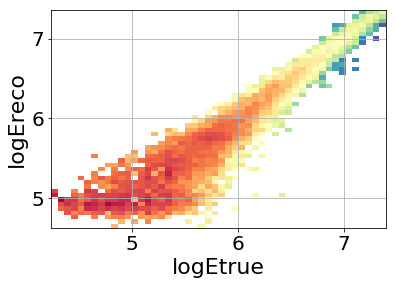

In [10]:
plt.figure()
abc = plt.hist2d(logTenergy, logPenergy, weights=Weight, bins=[50,50], 
                 norm=LogNorm(), cmap='Spectral_r')
plt.xlabel('logEtrue')
plt.ylabel('logEreco')



In [11]:
print '=============All required Data====================='
# ====================== 3yrs spectrum =================================
H4a_E = numpy.array([6.450, 6.525, 6.575, 6.625, 6.675, 6.725, 6.775, 6.825, 6.875, 6.925, 6.975, 7.025,
                     7.075, 7.125, 7.175, 7.225, 7.275, 7.325, 7.375, 7.425, 7.475, 7.525, 7.575, 7.625,
                     7.675, 7.725, 7.775, 7.825, 7.875, 7.925, 7.975, 8.050, 8.150, 8.250, 8.350, 8.450,
                     8.550, 8.650, 8.750, 8.850, 8.950, 9.050
                    ])

# dN/(dlnE dOmega dA dt)                                                                                                                                                        
H4a_Flux = numpy.array([4.874876e-07, 3.561436e-07, 2.881542e-07, 2.322555e-07, 1.858161e-07, 
                        1.479502e-07, 1.171621e-07, 9.287553e-08, 7.305793e-08, 5.719065e-08, 
                        4.479624e-08, 3.483035e-08, 2.720353e-08, 2.139004e-08, 1.678868e-08, 
                        1.325049e-08, 1.053227e-08, 8.369410e-09, 6.706060e-09, 5.352161e-09, 
                        4.268105e-09, 3.454297e-09, 2.792893e-09, 2.256138e-09, 1.776015e-09, 
                        1.401786e-09, 1.157379e-09, 9.151598e-10, 7.561862e-10, 5.815745e-10, 
                        4.670996e-10, 3.291779e-10, 2.072970e-10, 1.243117e-10, 7.042426e-11, 
                        4.514084e-11, 2.294802e-11, 1.415630e-11, 7.593821e-12, 4.311962e-12, 
                        2.221199e-12, 9.199803e-13])
H4a_Flux_err = numpy.array([2.099E-10,2.498E-10, 2.234E-10, 1.995E-10, 1.778E-10,1.581E-10,
                                1.402E-10,1.245E-10, 1.102E-10, 9.725E-11, 8.592E-11,7.563E-11,
                                6.674E-11,5.910E-11, 5.230E-11, 4.640E-11, 4.132E-11,3.681E-11,
                                3.292E-11,2.939E-11, 2.622E-11, 2.359E-11, 2.116E-11,1.904E-11,
                                1.687E-11,1.497E-11, 1.359E-11, 1.208E-11, 1.098E-11,9.633E-12,
                                8.617E-12,5.120E-12, 4.053E-12, 3.137E-12, 2.360E-12,1.889E-12,
                                1.343E-12,1.061E-12, 7.791E-13, 5.867E-13, 4.195E-13,2.774E-13])

Syst_high = numpy.array([3.67606E-08, 2.86443E-08, 2.29773E-08, 1.89148E-08, 1.56349E-08,
                             1.25324E-08, 1.00030E-08, 8.02676E-09, 6.44238E-09, 5.16727E-09,
                             4.08505E-09, 3.23167E-09, 2.51830E-09, 1.89323E-09, 1.56199E-09,
                             1.18808E-09, 9.15250E-10, 7.76948E-10, 5.77767E-10, 4.98760E-10,
                             3.83445E-10, 3.09929E-10, 2.24941E-10, 2.14448E-10, 1.50013E-10,
                             1.37281E-10, 1.00461E-10, 7.26802E-11, 9.11337E-11, 4.44967E-11,
                             4.16217E-11, 3.27000E-11, 2.01334E-11, 1.29110E-11, 6.31818E-12,
                             4.07038E-12, 2.25524E-12, 1.73793E-12, 2.49281E-12, 4.32947E-13,
                             4.57711E-13, 4.79512E-13])
Syst_low = numpy.array([4.25304E-08, 3.25328E-08, 2.76305E-08,
                            2.16275E-08, 1.79527E-08, 1.39663E-08,1.12869E-08, 9.28657E-09,
                             7.07005E-09, 5.84316E-09, 4.29775E-09, 3.57590E-09, 2.67481E-09,
                            2.11350E-09, 1.61419E-09, 1.18820E-09, 1.02943E-09, 8.14132E-10,
                             5.88148E-10, 5.10979E-10, 3.93476E-10, 3.05541E-10, 2.36948E-10,
                            2.04678E-10, 2.00286E-10, 1.29993E-10,8.40936E-11, 9.32723E-11,
                             6.44922E-11, 5.92049E-11, 3.71297E-11, 3.06249E-11, 2.52663E-11,
                             9.83157E-12, 7.25513E-12, 4.36792E-12, 2.82607E-12, 1.25291E-12,
                             1.99597E-12, 5.95644E-13, 3.92410E-13, 2.49633E-13])
H4a_E_bins = numpy.array([ 6.4, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8,
                           6.85, 6.9, 6.95, 7., 7.05, 7.1, 7.15, 7.2, 7.25,
                           7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7,
                           7.75, 7.8, 7.85, 7.9, 7.95, 8., 8.1, 8.2, 8.3, 8.4, 8.5,
                           8.6, 8.7, 8.8, 8.9, 9., 9.1 ])

# =================== HAWC All-particle Spectrum ===========================
Hawc_E_bins = numpy.array([4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  
                           5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7])
Hawc_E      = 0.5*(Hawc_E_bins[1:]+Hawc_E_bins[:-1])

Hawc_Flux   = numpy.array([4.7968e-7, 2.6922e-7, 1.5163e-7, 8.4947e-8, 4.7823e-8, 2.6761e-8, 
                          1.4823e-8, 8.1839e-9, 4.4769e-9, 2.4193e-9, 1.2781e-9, 6.7636e-10, 
                          3.5835e-10, 1.9107e-10, 1.0346e-10, 5.4882e-11, 2.9284e-11])
Herr_factor= numpy.array([1e-7, 1e-7, 1e-7, 1e-8, 1e-8, 1e-8, 1e-8, 1e-9, 1e-9, 1e-9, 1e-9, 
                          1e-10, 1e-10, 1e-10, 1e-10, 1e-11, 1e-11])
Hawc_err   = numpy.array([0.0002, 0.0001, 0.0001, 0.0007, 0.0005, 0.0003, 0.0002, 0.0015, 0.0010, 0.0007, 0.0004,
                          0.0027, 0.0017, 0.0011, 0.0007, 0.0047, 0.0030])*Herr_factor
Hawc_sysmc = numpy.array([0.5901, 0.2323, 0.1189,  0.7137, 0.3896, 0.2536, 0.1305, 0.8041, 0.4488, 0.2504, 0.1349, 
                          0.6441, 0.3331, 0.1644, 0.0892, 0.4659, 0.2402])*Herr_factor
Hawc_sysl  = numpy.array([0.8530, 0.4467, 0.2356, 1.2419, 0.6614, 0.3522, 0.1869, 0.9947, 0.5281, 0.2787, 0.1447, 
                          0.7576, 0.3995, 0.2134, 0.1166, 0.6286, 0.3441])*Herr_factor
Hawc_sysh  = numpy.array([0.4288, 0.2360, 0.1315, 0.7352, 0.4171, 0.2377, 0.1357, 0.7830, 0.4547, 0.2655, 0.1544, 
                          0.9164, 0.5544, 0.3430, 0.2184, 1.3920, 0.9642])*Herr_factor

hl = numpy.sqrt(Hawc_sysmc**2 + Hawc_sysl**2)
hh = numpy.sqrt(Hawc_sysmc**2 + Hawc_sysh**2)

# ==========================================================================
# ========================= STA2 Spectrum ==================================
# ==========================================================================
# =================== MC ======================
eff,error_eff   = efficiency(tenergy, weight,
                             loge_bins=loge_bins,
                             particle=particle,
                             composition_model=composition_model
                            )
AeffO           = effective_area(eff, loge_bins) # Aeff before fitting.
ErrAeff         = effective_area(error_eff, loge_bins)
Aeff,popt_eff   = effective_area(eff, loge_bins, fitted=True)

# ================== DATA =====================
duration = 28548809.85074771
'''
duration  :  [ 28548809.85074771]
durationHigh :  [ 28609806.45698332]
durationLow  :  [ 28487813.24451206]
'''

# ============= Asterix: /data/icet0/rkoirala/LowEnergy/RandomForest$ python energy_spectrum.py ============
if len(mid_logE)==17 and cos1==1 and cos2==0.9:
    #NEobs = numpy.array([0, 0, 0, 335082, 15433672, 8375696, 4860389, 3633148, 2782233, 1368630, 501927, 
    #                     279053, 112795, 51238, 19914, 6769, 3587])
    NEobs = numpy.array([0, 0, 0, 528112, 15128466, 8074525, 4753960, 3476123, 2731596, 1243001, 484928, 
                         269906, 107815, 48760, 18932, 6504, 3372])
elif len(mid_logE)==34 and cos1==1 and cos2==0.9:
    NEobs = numpy.array([0, 0, 0, 0, 0, 0, 2079, 333003, 5196760, 10236912, 5099600, 3276096, 2417850, 2442539, 2049604, 1583544, 1388193, 1394040, 858061, 510569, 281692, 220235, 156661, 122392, 66477, 46318, 31475, 19763, 12182, 7732, 4365, 2404, 2089, 1498])

# ============== SYSTEMATICS =================
# ===== Composition Systematics for STA2 =====
sys_ene_bins = numpy.array([5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0])
'''hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
sys_comp_low_frac      = hf.root.composition_uncertainty_low[:]
sys_comp_high_frac     = hf.root.composition_uncertainty_high[:]
sys_vemcal_low_frac    = hf.root.vemcal_uncertainty_low[:]
sys_vemcal_high_frac   = hf.root.vemcal_uncertainty_high[:]
sys_pressure_low_frac  = hf.root.pressure_uncertainty_low[:]
sys_pressure_high_frac = hf.root.pressure_uncertainty_high[:]
hf.close()'''

if len(mid_logE)==17: 
    sys_ene_bins = numpy.array([5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0])
    # This file is created in systematics_study.ipynb
    try:
        hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
        sys_comp_low_frac      = hf.root.composition_uncertainty_low[:]
        sys_comp_high_frac     = hf.root.composition_uncertainty_high[:]
        #sys_vemcal_low_frac    = hf.root.vemcal_uncertainty_low[:]
        #sys_vemcal_high_frac   = hf.root.vemcal_uncertainty_high[:]
        sys_aeff_low_frac      = hf.root.effective_area_uncertainty_low[:]
        sys_aeff_high_frac     = hf.root.effective_area_uncertainty_high[:]
        sys_pressure_low_frac  = hf.root.pressure_uncertainty_low[:]
        sys_pressure_high_frac = hf.root.pressure_uncertainty_high[:]
        sys_temp_low_frac  = hf.root.temperature_uncertainty_low[:]
        sys_temp_high_frac = hf.root.temperature_uncertainty_high[:]
        sys_pres_plus_temp_low = sys_pressure_low_frac-sys_temp_low_frac
        sys_pres_plus_temp_high= sys_pressure_high_frac+sys_temp_high_frac

        #sys_duration_low_frac  = hf.root.duration_uncertainty_low[:]
        #sys_duration_high_frac = hf.root.duration_uncertainty_high[:]
        pressure_flux_shift    = hf.root.pressure_flux_shift[:]
        pressure_correction_factor = 1.-pressure_flux_shift # correct for flux change due to different atm. pressure.

        hf.close()

        # Note: This total does not include uncertainty due to unfolding. That will be added later once calculated.
        sys_total_low_frac  = systematics_quadrature([sys_comp_low_frac,  
                                                      #sys_pressure_low_frac, 
                                                      sys_pres_plus_temp_low,
                                                      sys_aeff_low_frac, 
                                                      #sys_duration_low_frac
                                                     ])
        sys_total_high_frac = systematics_quadrature([sys_comp_high_frac, 
                                                      #sys_pressure_high_frac, 
                                                      sys_pres_plus_temp_high,
                                                      sys_aeff_high_frac, 
                                                      #sys_duration_high_frac
                                                     ])
    except:
        print 'Run systematics_study.ipynb after this script is ran completely. Temporarily uncertainty is set 0.'
        sys_total_low_frac      = 0.
        sys_total_high_frac     = 0.
        pressure_correction_factor = 1.

else:
    sys_total_low_frac      = 0.
    sys_total_high_frac     = 0.
    try:
        hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
        pressure_flux_shift    = hf.root.pressure_flux_shift[:]
        hf.close()
        pressure_correction_factor = numpy.array([]) # interpolate to get all mid points
        for i in range(len(pressure_flux_shift)):
            pressure_correction_factor = numpy.append(pressure_correction_factor, 1.-pressure_flux_shift[i])
            if i!=(len(pressure_flux_shift)-1):
                mid_pres_shift = 0.5*(pressure_flux_shift[i]+pressure_flux_shift[i+1])
            else:
                mid_pres_shift = pressure_flux_shift[i]
            pressure_correction_factor = numpy.append(pressure_correction_factor, 1.-mid_pres_shift)
        
        print len(pressure_correction_factor), len(pressure_flux_shift)
    except:
        pressure_correction_factor = 1.


=============All required Data=====================
Particle:  ['proton', 'helium', 'oxygen', 'iron']


In [28]:
ene_mask = (mid_logE>=5.4)*(mid_logE<=7.)
print ''
print 'comp', list(sys_comp_high_frac[ene_mask])
print 'atmo', list(sys_pres_plus_temp_high[ene_mask])
print 'aeff', list(sys_aeff_high_frac[ene_mask])
print ''

#sys_comp_low_frac,  
#sys_pres_plus_temp_low,
#sys_aeff_low_frac,


comp [0.0, 0.0, 0.019392911925885395, 0.018091777245104274, 0.021878225743270613, 0.026892195536937308, 0.05302031224222257, 0.06082886570984418]
atmo [0.010757886548514829, 0.008016010164898649, 0.005384284273373774, 0.006587699719990421, 0.009515992551874693, 0.010331858164888871, 0.01014657747574611, 0.027445276379077236]
aeff [0.0622152676017913, 0.07000377191748317, 0.0375211616526568, 0.029232417064122933, 0.027205704263978107, 0.026823930984620006, 0.026758502146456392, 0.026747835994844853]



In [12]:
print "=================Scaling Factor================="
te_list   = []
# Calculate Mean energy for each s30 bins.                                                                                      
for i in range(len(mid_logE)):
    mask = (tenergy>=loge_bins[i])*(tenergy<loge_bins[i+1])
    t_e  = tenergy[mask]
    wt_  = weight[mask]
    if numpy.sum(wt_)>0:
        m_e = numpy.average(10**t_e, weights=wt_)
    else:
        m_e = 10**mid_logE[i]
    te_list.append(m_e)
meanEtrue = numpy.array(te_list)

if which_scaling=='scale_midlogE':
    scaleE_exp = 10**mid_logE.copy() # mid_logE here is [4.1, 4.3, 4.5, .... 7.1,7.3]
    scaleE_3yr = 10**H4a_E.copy()
    scaleE_mc  = 10**mid_logE.copy()
elif which_scaling=='scale_meanEtrue':
    scaleE_exp = meanEtrue.copy() # mid_logE here is [4.1, 4.3, 4.5, .... 7.1,7.3]
    scaleE_3yr = 10**H4a_E.copy()# scaleE_3yr is close to meanEtrue than mid points.
    scaleE_mc  = meanEtrue.copy()
elif which_scaling=='scale_fitPowerLaw':
    scaleE_exp = numpy.array([12420.579349950242, 19685.291658159233, 31199.084740628099, 
                              49447.21701643883, 78368.557635501289, 124205.79349950244, 
                              196852.91658159229, 311990.84740628098, 494472.17016438843, 
                              782655.33329659724, 1234585.9885411051, 1954644.5139673189, 
                              3100329.7423857474, 4878105.7923115855, 7731276.6623397646, 
                              12253247.751175763, 19420088.946377922])
    scaleE_3yr = numpy.array([ 2.80313070e+06,   3.34510829e+06,   3.75308690e+06,   4.21068436e+06,
                               4.72399659e+06,   5.30006065e+06,   5.94656913e+06,   6.67182926e+06,
                               7.48529662e+06,   8.39836321e+06,   9.42265114e+06,   1.05720389e+07,
                               1.18630033e+07,   1.33111690e+07,   1.49356242e+07,   1.67594318e+07,
                               1.88053248e+07,   2.11009686e+07,   2.36768512e+07,   2.65649850e+07,
                               2.98088692e+07,   3.34499757e+07,   3.75308690e+07,   4.21033605e+07,
                               4.72313718e+07,   5.30102526e+07,   5.94843875e+07,   6.67370583e+07,
                               7.48752553e+07,   8.39836321e+07,   9.42545645e+07,   1.11447653e+08,
                               1.40248908e+08,   1.76308068e+08,   2.21973255e+08,   2.79521077e+08,
                               3.51803901e+08,   4.42894871e+08,   5.57571608e+08,   7.01941067e+08,
                               8.83691446e+08,   1.11250162e+09])
    scaleE_mc = numpy.array([12400.990842717876, 19654.245966396182, 31149.880635097594, 
                             49369.233764542398, 78244.962510444631, 124009.9084271788, 
                             196542.45966396181, 311498.80635097594, 493692.33764542424, 
                             781422.84061400837, 1232012.080715836, 1947540.0269293007, 
                             3095480.6935283612, 4881883.2926667258, 7737263.596937147, 
                             12262736.403062863, 19435127.446159422])
else:
    scaleE_exp = meanEtrue.copy() # mid_logE here is [4.1, 4.3, 4.5, .... 7.1,7.3]
    scaleE_3yr = 10**H4a_E.copy()# scaleE_3yr is close to meanEtrue than mid points.
    scaleE_mc  = meanEtrue.copy()
    
ene_mask    = (mid_logE>=5.4)*(mid_logE<=7.0) 
mid_logE    = numpy.log10(scaleE_mc)
mid_logE_mc = numpy.log10(scaleE_mc)
mid_logE_exp= numpy.log10(scaleE_exp)

print 'mid_logE: ', list(mid_logE)

=================Scaling Factor=================
mid_logE:  [4.1, 4.326801414233167, 4.513454232569235, 4.704230027942328, 4.906643622522372, 5.112094286980394, 5.306862791236674, 5.497371082259108, 5.703164655708093, 5.888885058376492, 6.092112007140827, 6.292490217681279, 6.4899835923016775, 6.68429448077758, 6.8871139294310195, 7.090901697509304, 7.28285006864312]


In [13]:
NEobs_err       = numpy.sqrt(NEobs)
NEobs_flux  = cr_flux(NEobs,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2,
                  duration=duration
                 )
NEobs_flux_err = cr_flux(NEobs_err,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2,
                  duration=duration
                 )

# Rate is used to make it comparable to MC. UnivariateSpline fit uses 's' parameter
# which is equivalent to sum of least squared <= s. We can use same 's' for Data and
# MC if we use rate of data instead of regular histogram.
NEobs_rate           = NEobs/duration
NEobs_rate_err       = NEobs_err/duration

# =================== Quantities for Flux ====================
unscaled_py     = numpy.histogram(penergy, bins=loge_bins, 
                                    weights=weight)[0]
unscaled_ty     = numpy.histogram(tenergy, bins=loge_bins, 
                                    weights=weight)[0]
unscaled_err_py = numpy.sqrt(numpy.histogram(penergy, 
                        bins=loge_bins, 
                        weights=((weight*weight)))[0])
unscaled_err_ty = numpy.sqrt(numpy.histogram(tenergy, 
                        bins=loge_bins, 
                        weights=((weight*weight)))[0])

# =================== Quantities for Unfolding ====================
response_hist     = numpy.histogram2d(penergy, tenergy, 
                          bins=[loge_bins, loge_bins],
                          weights=weight
                         )[0]
response_hist_err =  numpy.histogram2d(penergy, tenergy, 
                           bins=[loge_bins, loge_bins],
                           weights=((weight*weight)))[0]

#efficiencies = numpy.ones(len(mid_logE)) # Aeff is taken into account while calculating flux.
efficiencies = numpy.sum(response_hist, axis=0)/unscaled_ty
column_sums  = response_hist.sum(axis=0) # column_sums=hist(tenergy, bins=loge_bins)
norm_factor  = efficiencies/column_sums

# =================================================================
# ===== Stuff that goes inside "pyunfold.iterative_unfold" ========
# =================================================================
# ======= Things that does not change ============
#response_hist[numpy.where(response_hist==0)]=1e-20
response     = numpy.nan_to_num(response_hist * norm_factor)
response_err = numpy.nan_to_num(response_hist_err * norm_factor)
efficiencies = numpy.nan_to_num(efficiencies)
efficiencies_err  = numpy.nan_to_num(numpy.sum(errorXbyY(response_hist, unscaled_ty, 
                                        response_hist_err, unscaled_err_ty), axis=0))

hf = tables.open_file('response_matrix%s.h5'%name, 'w')
hf.create_array('/', 'response', response)
hf.create_array('/', 'response_err', response_err)
hf.create_array('/', 'efficiencies', efficiencies)
hf.create_array('/', 'efficiencies_err', efficiencies_err)
hf.close()

/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in divide


In [14]:
print '========== Tune Parameter Here =============='
# ======= Things that can change ==================
#fit_mask = 1*(mid_logE>=4.6) #fit values within 5.4 to 7.0 and rest seperately.
#degree   = 2 # this is just a regularizer. Get rid of first 3 empty bins for Iron assumption.
fit_mask = 1*(mid_logE>=4.6) #fit values within 5.4 to 7.0 and rest seperately.
degree   = 2 # this is just a regularizer. Get rid of first 3 empty bins for Iron assumption.

logger       = pyunfold.Logger()
#regularizer  = pyunfold.callbacks.SplineRegularizer(degree=degree, smooth=1e-1, groups=fit_mask)
regularizer  = pyunfold.callbacks.PolynomialRegularizer(degree=degree, groups=fit_mask)

if which_prior=='jeffreys':
    prior        = pyunfold.priors.jeffreys_prior(mid_logE) #uniform_prior, jeffreys_prior
if which_prior=='uniform':
    prior        = pyunfold.priors.uniform_prior(len(mid_logE)) #uniform_prior, jeffreys_prior
if which_prior=='NEobs':
    prior        = (1.*NEobs)/numpy.sum(NEobs)
    prior[:2]    = numpy.array(2*[prior[2]]) # Replace 0 with some number to prevent 'nan' in log
    prior        = prior/sum(prior)
if which_prior=='MCobs':
    prior        = (1.*unscaled_py)/numpy.sum(unscaled_py)
    prior[:2]    = numpy.array(2*[prior[2]])
    prior        = prior/sum(prior)
if which_prior=='MCtrue':
    prior        = (1.*unscaled_ty)/numpy.sum(unscaled_ty)
if which_prior=='h4a':
    modh4a       = H4a(particle='all', E=10**mid_logE)
    prior        = modh4a/numpy.sum(modh4a)
    
ts           ='ks'          # ‘ks’, ‘chi2’, ‘bf’, ‘rmd’}
ts_stopping  = 1e-5
max_iter     = 100
cov_type     = 'multinomial'
return_iterations=True      #Whether to return unfolded distributions for each iteration
callbacks    = [logger, regularizer]
# =================================================================

========== Tune Parameter Here ==============


Response matrix remains constant througout the process. The only thing that changes in iterative unfolding is the probability of occurance of cause.

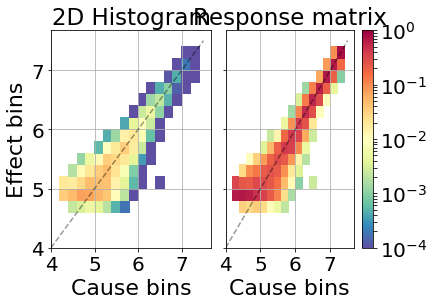

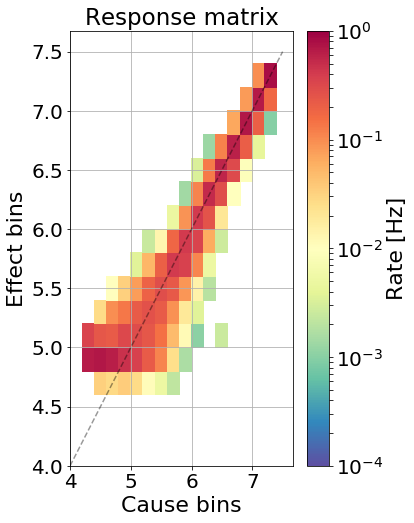

In [15]:
"""
Accent, Accent_r, 
Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, 
CMRmap, CMRmap_r, 
Dark2, Dark2_r, 
GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, 
OrRd, OrRd_r, Oranges, Oranges_r, 
PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, 
    PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, 
    PuRd_r, Purples, Purples_r, 
RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, 
    RdYlGn_r, Reds, Reds_r, 
Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, 
Wistia, Wistia_r, 
YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, 
-----------------------
afmhot, afmhot_r, autumn, autumn_r, 
binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, 
cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, 
    cubehelix_r, 
flag, flag_r, 
gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, 
    gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, 
    gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, 
    gnuplot2_r, gnuplot_r, gray, gray_r, 
hot, hot_r, hsv, hsv_r, 
inferno, inferno_r, 
jet, jet_r, 
magma, magma_r, 
nipy_spectral, nipy_spectral_r, 
ocean, ocean_r, 
pink, pink_r, plasma, plasma_r, prism, prism_r, 
rainbow, rainbow_r, 
seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, 
terrain, terrain_r, 
viridis, viridis_r, 
winter, winter_r
"""
# 'Spectral_r', 'bwr', 'jet', 
cmap = 'Spectral_r'

X, Y = numpy.meshgrid(loge_bins, loge_bins)
fig = plt.figure()
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:3, :2])
ax2 = plt.subplot(gs[:3, 2:4])

# =========True Vs Reco Energy Histogram=============
ax1.pcolormesh(X,Y,response_hist, norm=LogNorm(), cmap=cmap, vmin=1e-4, vmax=1)
ax1.set(xlabel='Cause bins', ylabel='Effect bins',
       title='2D Histogram')
ax1.grid()
ax1.plot([4,7.5], [4,7.5], 'k--', alpha=0.4)
ax1.set_xticks(numpy.linspace(4.0,7.0,4))
# =========Response Matrix=============
pcm = ax2.pcolormesh(X,Y,response, norm=LogNorm(), cmap=cmap, vmin=1e-4, vmax=1)
ax2.set(xlabel='Cause bins', title='Response matrix')
ax2.set_yticklabels([])
ax2.grid()
ax2.plot([4,7.5], [4,7.5], 'k--', alpha=0.4)
ax2.set_xticks(numpy.linspace(4.0,7.0,4))
plt.colorbar(pcm)
if savefig:
    figname='response_matrix_%s_%s_len%i_%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')

# ====== response matrix only =========
plt.figure(figsize=(5,8))
pcm = plt.pcolormesh(X,Y,response, norm=LogNorm(), cmap=cmap, vmin=1e-4, vmax=1)
ax = plt.gca()
ax.set(xlabel='Cause bins', ylabel='Effect bins', title='Response matrix')
plt.grid()
plt.plot([4,7.5], [4,7.5], 'k--', alpha=0.4)
ax.set_xticks(numpy.linspace(4.0,7.0,4))
plt.colorbar(pcm, label='Rate [Hz]')
if savefig:
    plt.savefig(rfr_savedir+'response_matrix_only_%s_%s_len%i_%s'%(composition_model,particle,lenbins,name)+'.png', 
                bbox_inches='tight')


/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/pyunfold/callbacks.py:198: RuntimeWarning: divide by zero encountered in log10
  poly_fitted = np.poly1d(np.polyfit(x_group, np.log10(y_group), self.degree))
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in divide
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in divide


Iteration 1: ts = 0.3970, ts_stopping = 1e-05
Iteration 2: ts = 0.0456, ts_stopping = 1e-05
Iteration 3: ts = 0.0064, ts_stopping = 1e-05
Iteration 4: ts = 0.0012, ts_stopping = 1e-05
Iteration 5: ts = 0.0003, ts_stopping = 1e-05
Iteration 6: ts = 0.0001, ts_stopping = 1e-05
Iteration 7: ts = 0.0000, ts_stopping = 1e-05
Iteration 8: ts = 0.0000, ts_stopping = 1e-05
NEobs Rate
[0.1217607  0.09568161 0.0435395  0.01698593 0.00945419 0.00377651
 0.00170795 0.00066314]
Unfolded NE Rate
[0.10461292 0.07316623 0.04518194 0.02371421 0.01049349 0.00424424
 0.00166779 0.00065864]
Flux
[2.07083425e-05 9.29484648e-06 4.82520753e-06 2.39553727e-06
 1.04271338e-06 4.19742241e-07 1.64714672e-07 6.50240461e-08]
stat error
[1.52212630e-06 5.73086549e-07 3.72954310e-07 1.95778878e-07
 7.70051619e-08 2.97750065e-08 1.07208667e-08 4.28689561e-09]
sys low
[3.46155306e-06 1.17112326e-06 7.03184116e-07 3.88629333e-07
 1.33966985e-07 3.71703585e-08 1.18370535e-08 4.42183902e-09]
sys high
[1.94236748e-06 8.59

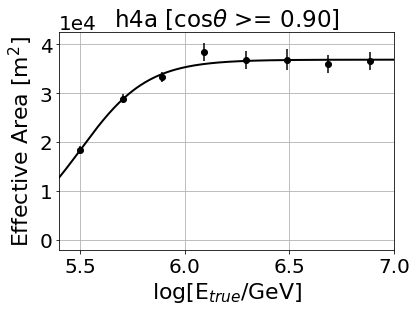

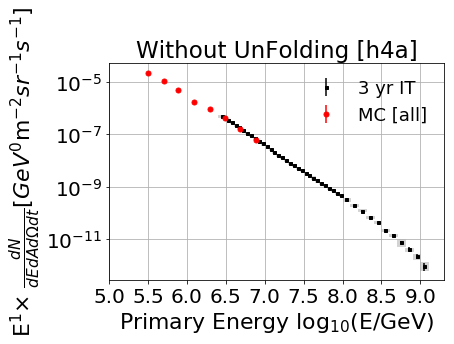

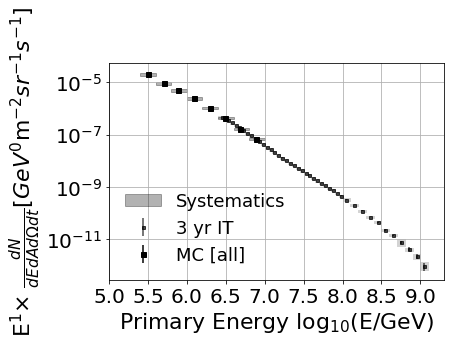

In [16]:
scale     = 1

# =============== Scale 3 yrs IT Spectrum Result ================
scaling_factor = (10**H4a_E)**(scale-1)
Flux           = H4a_Flux*scaling_factor
Error_flux     = H4a_Flux_err*scaling_factor
Syst_err_high  = Syst_high * scaling_factor
Syst_err_low   = Syst_low * scaling_factor

# ================== Plot Effective Area ====================
plt.figure()
effx = numpy.linspace(4,7.0,501)
plt.errorbar(mid_logE, AeffO, yerr=ErrAeff, color='k', marker='o', linestyle='')
plt.plot(effx, sigmoid_func(effx, *popt_eff), 'k', lw=2)
plt.xlabel(r'log[E$_{true}$/GeV]')
plt.ylabel(r'Effective Area [m$^2$]')
plt.title(r'%s [cos$\theta$ >= %.2f]'%(composition_model, cos2))
plt.xlim(5.4,7.0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if savefig:
    figname='effective_area_%s_%s_len%i_%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')


# Calculate Flux. Both before and after unfolding.
# ===================== Before Unfolding ===================== 
penergy_y   = unscaled_py.copy()
tenergy_y   = unscaled_ty.copy()
error_eney  = unscaled_err_py.copy()
error_enety = unscaled_err_ty.copy()

reg_fx  = cr_flux(penergy_y,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
reg_err = cr_flux(error_eney,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_fx    = cr_flux(tenergy_y,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_err   = cr_flux(error_enety,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
# ===================== After Unfolding ===================== 
unfolded_result = pyunfold.iterative_unfold(data=penergy_y,
                                   data_err=numpy.nan_to_num(error_eney),
                                   response=response,
                                   response_err=response_err,
                                   efficiencies=efficiencies,
                                   efficiencies_err=efficiencies_err,
                                   prior=prior,
                                   ts=ts, ts_stopping=ts_stopping,
                                   callbacks=callbacks,
                                   max_iter=max_iter,
                                   return_iterations=return_iterations
                                  )

if return_iterations:
    maxiter = max(unfolded_result['num_iterations'])
    unfolded= unfolded_result['unfolded'][maxiter-1]
    stat_err= unfolded_result['stat_err'][maxiter-1]
    sys_err = unfolded_result['sys_err'][maxiter-1]
    unfolding_matrix = unfolded_result['unfolding_matrix'][maxiter-1]
        
else:
    unfolded= unfolded_result['unfolded']
    stat_err= unfolded_result['stat_err']
    sys_err = unfolded_result['sys_err']
    unfolding_matrix = unfolded_result['unfolding_matrix']
    
flux       = cr_flux(unfolded,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2
                 )
stat_error = cr_flux(stat_err,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2
                 )
sys_error  = cr_flux(sys_err,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2
                 )
# ==================== Plot Flux Before Unfolding ====================
plt.figure()
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], 
                     color='lightgrey') 
plt.errorbar(mid_logE[ene_mask], reg_fx[ene_mask], yerr=reg_err[ene_mask], markersize=5,
                 color='r', fmt=' ', marker='o', label='MC ['+particle+']')
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]')
plt.legend(loc='best', frameon=False)
plt.title('Without UnFolding [%s]'%composition_model)
plt.xlim(5.0,9.3)
plt.yscale('log')
if savefig:
    figname='CR_flux_without_unfolding_%s_%s_len%i_%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    
# ==================== Plot Flux After Unfolding ====================
# Note: Fraction of composition systematics is calculated in systematics_study.ipynb
STA2_midE = mid_logE_mc[ene_mask]
bin_width = numpy.diff(mid_logE_mc)[0]
STA2_loge = loge_bins[numpy.where((loge_bins>=STA2_midE[0]-bin_width)*(loge_bins<=STA2_midE[-1]+bin_width))]
STA2_flux = flux[ene_mask]
STA2_err  = stat_error[ene_mask]
# ===Quadrature Sum of Systematics===
#sys_low_frac  = systematics_quadrature([sys_error, sys_comp_low_frac,  sys_vemcal_low_frac, sys_pressure_low_frac])
#sys_high_frac = systematics_quadrature([sys_error, sys_comp_high_frac, sys_vemcal_high_frac, sys_pressure_high_frac])

sys_low_frac  = systematics_quadrature([sys_error/flux, sys_total_low_frac])
sys_high_frac = systematics_quadrature([sys_error/flux, sys_total_high_frac])

STA2_sys_low  = (sys_low_frac*flux)[ene_mask]
STA2_sys_high = (sys_high_frac*flux)[ene_mask]

# ============Print Result=============
print 'NEobs Rate'
print NEobs_rate[ene_mask]
print 'Unfolded NE Rate'
print unfolded[ene_mask]
print 'Flux'
print STA2_flux
print 'stat error'
print STA2_err
print 'sys low'
print STA2_sys_low
print 'sys high'
print STA2_sys_high

plt.figure()
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', alpha=0.7, fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], color='lightgrey') 
plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='s', markersize=5, label='MC ['+particle+']')

for i in range(int(sum(ene_mask))):
    if i==0:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3, label='Systematics') 
    else:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3,)
        
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 
    
plt.yscale('log')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]')
plt.legend(loc='best', frameon=False)
plt.xlim(5.0,9.3)
if savefig:
    figname='CR_flux_unfolded_%s_%s_len%i_%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')


print name
hf = tables.open_file(rfr_savedir+'unfolding_flux_result%s.h5'%name, 'w')
hf.create_array('/', 'mid_logE_len%i'%lenbins, mid_logE)
hf.create_array('/', 'loge_bins_len%i'%lenbins, loge_bins)
hf.create_array('/', 'Aeff_len%i'%lenbins, Aeff)
hf.create_array('/', 'ErrAeff_len%i'%lenbins, ErrAeff)
hf.create_array('/', 'coszenith_len%i'%lenbins, numpy.array([cos1,cos2]))
hf.create_array('/', 'flux_mc_len%i'%lenbins, flux)
hf.create_array('/', 'stat_error_mc_len%i'%lenbins, stat_error)
hf.create_array('/', 'unfolding_matrix_mc_len%i'%lenbins, unfolding_matrix)
hf.close()


In [17]:
unfolded_result

,num_iterations,stat_err,sys_err,ts_iter,ts_stopping,unfolded,unfolding_matrix
0,1,"[0.0, 0.005578187700558996, 0.0052505903470770...","[0.0, 0.0023780148468307703, 0.002675771382504...",0.397023,0.00001,"[0.0, 0.0, 0.0, 0.10716294604847267, 0.1243722...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2,"[0.0, 0.006272651319230085, 0.0060590212348411...","[0.0, 0.0, 0.0, 0.004660091395243311, 0.002782...",0.045610,0.00001,"[0.0, 0.0, 0.0, 0.1898992235534802, 0.19333292...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3,"[0.0, 0.005937164176480726, 0.0057260262217346...","[0.0, 0.0, 0.0, 0.006381428582582195, 0.003715...",0.006405,0.00001,"[0.0, 0.0, 0.0, 0.21117900683653415, 0.2043892...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,4,"[0.0, 0.005642368449180149, 0.0054393302459685...","[0.0, 0.0, 0.0, 0.007945434410477214, 0.004441...",0.001233,0.00001,"[0.0, 0.0, 0.0, 0.21731121806690176, 0.2072360...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,5,"[0.0, 0.005422426612666778, 0.0052261749335312...","[0.0, 0.0, 0.0, 0.009359204769725165, 0.005089...",0.000274,0.00001,"[0.0, 0.0, 0.0, 0.21893998012237695, 0.2079569...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,6,"[0.0, 0.005264702464146623, 0.0050734702421963...","[0.0, 0.0, 0.0, 0.010640993908743816, 0.005700...",0.000067,0.00001,"[0.0, 0.0, 0.0, 0.21936570570726607, 0.2081425...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,7,"[0.0, 0.005152397106557113, 0.0049647734284578...","[0.0, 0.0, 0.0, 0.01180749474598964, 0.0062879...",0.000017,0.00001,"[0.0, 0.0, 0.0, 0.21947647253920818, 0.2081906...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,8,"[0.0, 0.005072848840990159, 0.0048877820962710...","[0.0, 0.0, 0.0, 0.012873311412912336, 0.006856...",0.000004,0.00001,"[0.0, 0.0, 0.0, 0.21334169515999818, 0.2022764...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


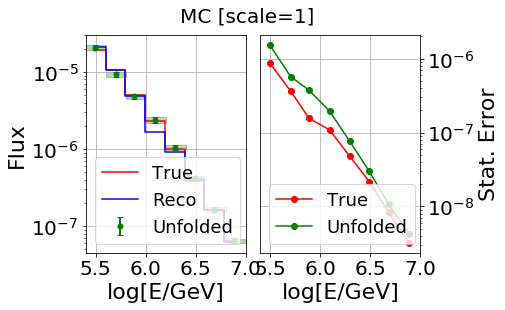

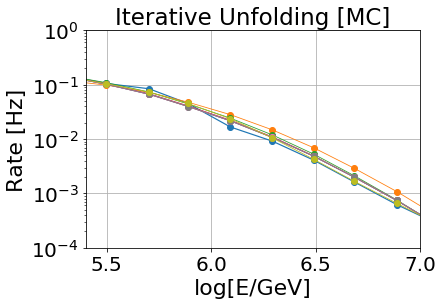

In [18]:
fig = plt.figure()
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:3, :2])
ax2 = plt.subplot(gs[:3, 2:4])
#plt.rcParams.update({'xtick.labelsize':20})

ax1.step(mid_logE[ene_mask], t_fx[ene_mask],   color='r', label='True'    , lw=1.5, where='mid')
ax1.step(mid_logE[ene_mask], reg_fx[ene_mask], color='b', label='Reco' , lw=1.5, where='mid')
ax1.errorbar(mid_logE[ene_mask], flux[ene_mask], yerr=stat_error[ene_mask], 
             color='g', label='Unfolded',
             elinewidth=2,
             capsize=3,
             ls='None', marker='.', ms=10, )

#
ax1.set_yscale('log')
ax1.set_xlabel('log[E/GeV]')
ax1.set_ylabel('Flux')
ax1.set_xticks(numpy.linspace(4.0,7.0,7))
ax1.set_xlim(5.4, 7.0)
ax1.legend(loc='best')
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
for i in range(int(sum(ene_mask))):                                                                                                                                                    
    ax1.fill_between(STA2_loge[i:i+2], (STA2_flux-sys_error[ene_mask])[i], 
                     (STA2_flux+sys_error[ene_mask])[i], color='g', alpha=0.3) 

ax2.plot(mid_logE[ene_mask], t_err[ene_mask], 'ro-', 
         label='True', lw=1.5)
ax2.plot(mid_logE[ene_mask], stat_error[ene_mask], 'go-', 
         label='Unfolded', lw=1.5)
ax2.set_xlabel('log[E/GeV]')
ax2.set_ylabel('Stat. Error')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax2.set_xticks(numpy.linspace(4.0,7.0,7))
ax2.set_xlim(5.4, 7.0)
ax2.set_yscale('log')
ax2.legend(loc='best')
plt.suptitle('MC [scale=%.0f]'%scale, fontsize=20)
if savefig:
    fn='unfolding_stat_error_comparison_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+fn, bbox_inches = 'tight')

if return_iterations:
    plt.figure()
    #plt.plot(mid_logE, prior, label='Prior', marker='o', lw=1.2)
    plt.plot(mid_logE, penergy_y, label='MC Reco', marker='o', lw=1.2)
    for i in range(maxiter):
        plt.plot(mid_logE, unfolded_result['unfolded'][i], marker='o', 
                 label='Iter:%i'%(i+1), lw=0.8)
    #plt.legend(loc='best')
    plt.yscale('log')
    plt.xlim(5.4,7.0)
    plt.ylim(1e-4,1e0)
    plt.xlabel('log[E/GeV]')
    plt.ylabel('Rate [Hz]')
    plt.title('Iterative Unfolding [MC]')
    if savefig:
        figname='unfolding_iteration_spectrum_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
        plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

    # ======Unfolding Matrix========
    if plot_unfolding:
        X,Y = numpy.meshgrid(loge_bins, loge_bins)
        for i in range(maxiter):
            plt.figure(figsize=(6,8))
            plt.pcolormesh(X, Y, unfolded_result['unfolding_matrix'][i], norm=LogNorm(), 
                           cmap='Spectral_r', vmin=1e-7, vmax=1e0)
            plt.xlabel('log[Etrue/GeV]')
            plt.ylabel('log[Ereco/GeV]')
            plt.grid()
            plt.title('Unfolding Matrix [MC, %i]'%(i+1))
            plt.plot([4,7.5], [4,7.5], 'k--', lw=1.5, alpha=0.3)
            plt.colorbar()
            ax = plt.gca()
            ax.set_xticks(numpy.linspace(4.0,7.0,4))
            if savefig:
                fn='unfolding_matrix_mc_iter%i_%s_%s_len%i_%s.png'%((i+1),composition_model,particle,lenbins,name)
                plt.savefig(rfr_savedir+fn, bbox_inches = 'tight')


Energy spectrum of MC data before and after unfolding.

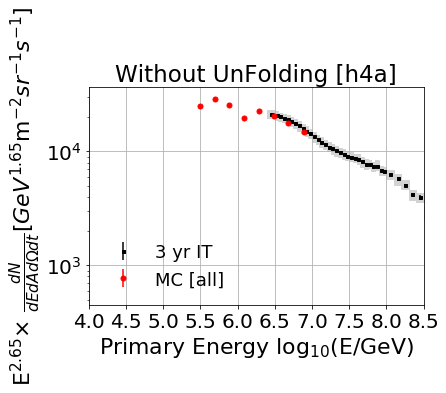

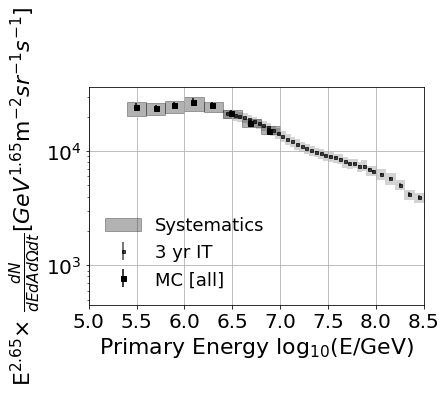

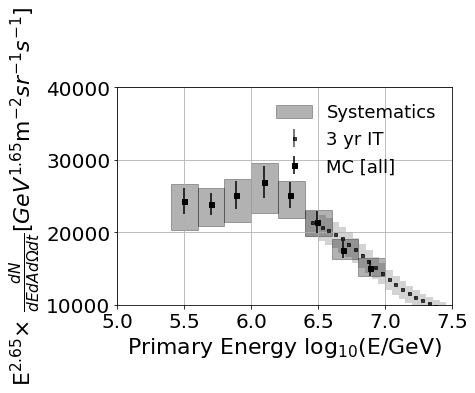

In [19]:
scale     = 2.65

# ---------------------------------------                                                                                                                                       
# 3 year IT spectrum (received from serap)                                                                                                                                      
# H4a_Flux = dN/(dlnE dOmega dA dt)                                                                                                                                             
# --------------------------------------- 
scale_factor_mc  = scale_factor_func(scaleE_mc, scale)
#scale_factor    = tenergy_y/unfolded
scale_factor_3yr = scale_factor_func(scaleE_3yr, scale)

Flux             = H4a_Flux*scale_factor_3yr
Error_flux       = H4a_Flux_err*scale_factor_3yr
Syst_err_high    = Syst_high*scale_factor_3yr
Syst_err_low     = Syst_low*scale_factor_3yr

# Calculate Flux. Both Unfolded and without unfolding.
# =============== Before Unfolding  ===============

penergy_y   = numpy.histogram(penergy, bins=loge_bins, 
                              weights=((10**penergy)**(scale-1)*weight))[0]
tenergy_y   = numpy.histogram(tenergy, bins=loge_bins, 
                              weights=((10**tenergy)**(scale-1)*weight))[0]
error_eney   = unscaled_err_py*scale_factor_mc
error_enety  = unscaled_err_ty*scale_factor_mc

reg_fx  = cr_flux(penergy_y , loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
reg_err = cr_flux(error_eney, loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_fx    = cr_flux(tenergy_y , loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_err   = cr_flux(error_enety,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)

# =============== After Unfolding ===============
if scale_unfolding:
    unfolded_energy_y = numpy.dot(penergy_y,unfolding_matrix)

    flux = cr_flux(unfolded_energy_y,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                  )
else:
    flux = scale_factor_mc*flux
    
stat_error = scale_factor_mc*stat_error
sys_error  = scale_factor_mc*sys_error

# ==================== Plot Flux Before Unfolding ====================
plt.figure()
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], 
                     color='lightgrey') 
plt.errorbar(mid_logE[ene_mask], reg_fx[ene_mask], yerr=reg_err[ene_mask], markersize=5,
                 color='r', fmt=' ', marker='o', label='MC ['+particle+']')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]')
plt.legend(loc='best', frameon=False)
plt.title('Without UnFolding [%s]'%composition_model)
plt.xlim(4.0,8.5)
plt.yscale('log')
if savefig:
    figname='CR_flux_without_unfolding_scale%.2f_%s_%s_len%i_%s.png'%(scale,composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    
# ==================== Plot Flux After Unfolding ====================
STA2_flux = flux[ene_mask]
STA2_err  = stat_error[ene_mask]
# ===Quadrature Sum of Systematics===
STA2_sys_low  = (scale_factor_mc[ene_mask])*STA2_sys_low
STA2_sys_high = (scale_factor_mc[ene_mask])*STA2_sys_high

plt.figure()
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', alpha=0.7, fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], color='lightgrey') 
plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='s', markersize=5, label='MC ['+particle+']')
for i in range(int(sum(ene_mask))):
    if i==0:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3, label='Systematics') 
    else:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3,)
        
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

if plot_h4a:
    model_scaling_factor = scale_factor_func(10**model_bin, scale)
    model_h4a  = (model_scaling_factor*H4a(particle='all', E=10**model_bin))
    plt.plot(model_bin, model_h4a, 'r--', label='H4a', alpha=0.4)
    
plt.yscale('log')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]')
plt.legend(loc='best', frameon=False)
plt.xlim(5.0,8.5)
if savefig:
    figname='CR_flux_unfolded_scale%.2f_%s_%s_len%i_%s.png'%(scale,composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')

# linear Y-scale
plt.figure()
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', alpha=0.7, fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], color='lightgrey') 
plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='s', markersize=5, label='MC ['+particle+']')
for i in range(int(sum(ene_mask))):
    if i==0:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3, label='Systematics') 
    else:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3,)
        
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

if plot_h4a:
    model_scaling_factor = scale_factor_func(10**model_bin, scale)
    model_h4a  = (model_scaling_factor*H4a(particle='all', E=10**model_bin))
    plt.plot(model_bin, model_h4a, 'r--', label='H4a', alpha=0.4)
    
#plt.yscale('log')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]')
plt.legend(loc='best', frameon=False)
plt.xlim(5.0,7.5)
plt.ylim(1e4,4e4)

if savehdf:
    hf = tables.open_file('flux_storage_temp%s.h5'%name, 'a')
    namemidE = 'STA2_midE_mc_%s_%s'%(which_scaling,which_prior)
    namelogE = 'STA2_loge'
    nameflux = 'STA2_flux_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    namestat = 'STA2_stat_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysL = 'STA2_sys_low_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysH = 'STA2_sys_high_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    nameAeff = 'Aeff_len%i_%s'%(len(mid_logE), particle)
    nameErrAeff= 'ErrAeff_len%i_%s'%(len(mid_logE), particle)
    nameAeff_popt   = 'popt_%s'%particle
    if cos2!=0.9:
        nameAeff = 'Aeff_len%i_%s_%s'%(len(mid_logE), particle, str(int(100*cos2)))
        nameErrAeff= 'ErrAeff_len%i_%s_%s'%(len(mid_logE), particle, str(int(100*cos2)))
        nameAeff_popt   = 'popt_%s_%s'%(particle, str(int(100*cos2)))

    if namemidE in hf.root:
        hf.remove_node('/', namemidE)
    if namelogE in hf.root:
        hf.remove_node('/', namelogE)
    if nameflux in hf.root:
        hf.remove_node('/', nameflux)
    if namestat in hf.root:
        hf.remove_node('/', namestat)
    if namesysL in hf.root:
        hf.remove_node('/', namesysL)
    if namesysH in hf.root:
        hf.remove_node('/', namesysH)
    if nameAeff in hf.root:
        hf.remove_node('/', nameAeff)
    if nameErrAeff in hf.root:
        hf.remove_node('/', nameErrAeff)
    if nameAeff_popt in hf.root:
        hf.remove_node('/', nameAeff_popt)
    hf.create_array('/', namemidE, STA2_midE)
    hf.create_array('/', namelogE, STA2_loge)
    hf.create_array('/', nameflux, STA2_flux)
    hf.create_array('/', namestat, STA2_err)
    hf.create_array('/', namesysL, STA2_sys_low)
    hf.create_array('/', namesysH, STA2_sys_high)
    hf.create_array('/', nameAeff, AeffO)
    hf.create_array('/', nameErrAeff, ErrAeff)
    hf.create_array('/', nameAeff_popt, popt_eff)
    hf.close()




Comapre true energy distribution with energy distribution after unfolding. Ideally, both distribution should be comparable. Plot on right hand side is the statistical error calculated for true energy distribution and taking into account of change in energy distribution in each iteration.

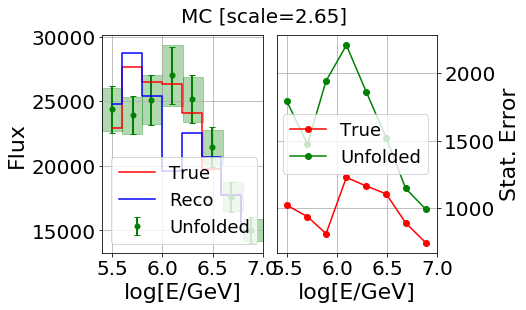

In [20]:
if True:
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[:3, :2])
    ax2 = plt.subplot(gs[:3, 2:4])

    ax1.step(mid_logE[ene_mask], t_fx[ene_mask],   color='r', label='True'    , lw=1.5, where='mid')
    ax1.step(mid_logE[ene_mask], reg_fx[ene_mask], color='b', label='Reco' , lw=1.5, where='mid')
    ax1.errorbar(mid_logE[ene_mask], flux[ene_mask], yerr=stat_error[ene_mask], 
                 color='g', label='Unfolded',
                 elinewidth=2,
                 capsize=3,
                 ls='None', marker='.', ms=10, )

    #ax1.set_yscale('log')
    ax1.set_xlabel('log[E/GeV]')
    ax1.set_ylabel('Flux')
    ax1.set_xticks(numpy.linspace(4,7.0,7))
    ax1.set_xlim(5.4, 7.0)
    ax1.legend(loc='best')
    for i in range(int(sum(ene_mask))):                                                                                                                                                    
        ax1.fill_between(STA2_loge[i:i+2], (STA2_flux-sys_error[ene_mask])[i], 
                         (STA2_flux+sys_error[ene_mask])[i], color='g', alpha=0.3) 

    ax2.plot(mid_logE[ene_mask], t_err[ene_mask], 'ro-', 
             label='True', lw=1.5)
    ax2.plot(mid_logE[ene_mask], stat_error[ene_mask], 'go-', 
             label='Unfolded', lw=1.5)
    ax2.set_xlabel('log[E/GeV]')
    ax2.set_ylabel('Stat. Error')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.set_ticks_position("right")
    ax2.set_xticks(numpy.linspace(4.0,7.0,7))
    #ax2.set_yscale('log')
    ax2.set_xlim(5.4, 7.0)
    ax2.legend(loc='best')
    plt.suptitle('MC [scale=%.2f]'%scale, fontsize=20)

Iteration 1: ts = 0.4110, ts_stopping = 1e-05
Iteration 2: ts = 0.0478, ts_stopping = 1e-05
Iteration 3: ts = 0.0064, ts_stopping = 1e-05
Iteration 4: ts = 0.0009, ts_stopping = 1e-05
Iteration 5: ts = 0.0002, ts_stopping = 1e-05
Iteration 6: ts = 0.0000, ts_stopping = 1e-05
Iteration 7: ts = 0.0000, ts_stopping = 1e-05
[4.1        4.32680141 4.51345423 4.70423003 4.90664362 5.11209429
 5.30686279 5.49737108 5.70316466 5.88888506 6.09211201 6.29249022
 6.48998359 6.68429448 6.88711393 7.0909017  7.28285007]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80171183e-03
 1.16715575e-03 2.73321177e-04 6.79461520e-05 2.11142431e-05
 9.06413856e-06 4.48091887e-06 2.17777130e-06 9.62038243e-07
 3.74231765e-07 1.52679155e-07 6.22582959e-08 2.20700703e-08
 9.05180643e-09]
[0.00000000e+00 7.30692507e-06 2.02136153e-06 1.71838688e-06
 2.93082946e-07 7.79439460e-08 2.98431877e-08 1.34389010e-08
 7.31904785e-09 5.35243902e-09 4.21614581e-09 2.37265330e-09
 1.25075457e-09 8.37325202e-10 5.69375400e-

/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in divide


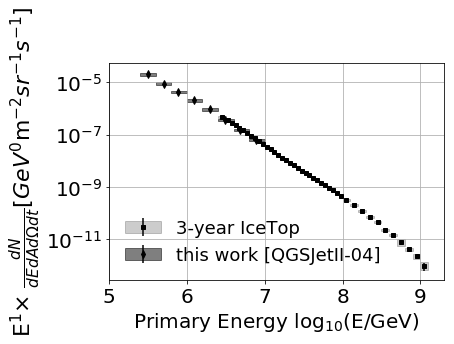

In [21]:
scale    = 1

# ================== Scale 3yr Spectrum ====================
scaling_factor = (10**H4a_E)**(scale-1)
Flux = H4a_Flux*scaling_factor
Error_flux = H4a_Flux_err*scaling_factor
Syst_err_high = Syst_high * scaling_factor
Syst_err_low = Syst_low * scaling_factor

# ================= Data Flux after Unfolding =================
unfolded_result = pyunfold.iterative_unfold(data=NEobs_rate,
                                   data_err=numpy.nan_to_num(NEobs_rate_err),
                                   response=response,
                                   response_err=response_err,
                                   efficiencies=efficiencies,
                                   efficiencies_err=efficiencies_err,
                                   prior=prior,
                                   ts=ts, ts_stopping=ts_stopping,
                                   callbacks=callbacks,
                                   max_iter=max_iter,
                                   return_iterations=return_iterations
                                  )

if return_iterations:
    maxiter = max(unfolded_result['num_iterations'])
    unfolded= unfolded_result['unfolded'][maxiter-1]
    stat_err= unfolded_result['stat_err'][maxiter-1]
    sys_err = unfolded_result['sys_err'][maxiter-1]
    unfolding_matrix = unfolded_result['unfolding_matrix'][maxiter-1]
        
else:
    unfolded= unfolded_result['unfolded']
    stat_err= unfolded_result['stat_err']
    sys_err = unfolded_result['sys_err']
    unfolding_matrix = unfolded_result['unfolding_matrix']
    
expflux  = cr_flux(unfolded,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                 )*pressure_correction_factor
stat_experr = cr_flux(stat_err,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                 )*pressure_correction_factor
sys_experror= cr_flux(sys_err,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                 )

# =================== Make Flux easy to Read ======================
print mid_logE
print expflux
print stat_experr
print 'kapuri ka'
STA2_midE = mid_logE_exp[ene_mask]
bin_width = numpy.diff(mid_logE_mc)[0]
STA2_loge = loge_bins[numpy.where((loge_bins>=STA2_midE[0]-bin_width)*(loge_bins<=STA2_midE[-1]+bin_width))]
STA2_flux = expflux[ene_mask]
STA2_err  = stat_experr[ene_mask]
# ===Quadrature Sum of Systematics===
#sys_low_frac  = systematics_quadrature([sys_experror/expflux, sys_comp_low_frac,  sys_vemcal_low_frac, sys_pressure_low_frac])
#sys_high_frac = systematics_quadrature([sys_experror/expflux, sys_comp_high_frac, sys_vemcal_high_frac, sys_pressure_high_frac])

sys_low_frac  = systematics_quadrature([sys_experror/expflux, sys_total_low_frac])
sys_high_frac = systematics_quadrature([sys_experror/expflux, sys_total_high_frac])

STA2_sys_low  = (sys_low_frac*expflux)[ene_mask]
STA2_sys_high = (sys_high_frac*expflux)[ene_mask]

# ============Print Result=============
print 'NEobs Rate'
print NEobs_rate[ene_mask]
print 'Unfolded NE Rate'
print unfolded[ene_mask]
print 'Flux'
print STA2_flux
print 'stat error'
print STA2_err
print 'sys low %'
print STA2_sys_low
print 'sys high %'
print STA2_sys_high

# ================ Plot Data Flux after Unfolding =================
plt.figure()
f1=plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=4)                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    f1f=plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], 
                     (Flux+Syst_err_high)[i], color='k', alpha=0.2) 
f2=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', fmt='d', markersize=5)
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

for i in range(int(sum(ene_mask))):
    f2f=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5)

plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)', fontsize=20)
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]',
               fontsize=22)
plt.yscale('log')
plt.legend([(f1,f1f),(f2,f2f)], ['3-year IceTop', 'this work [QGSJetII-04]'], loc='best', frameon=False)
plt.xlim(5.0,9.3)
if savefig:
    figname='CR_flux_experiment_scale%.2f_len%i_%s.png'%(scale,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')


hf = tables.open_file(rfr_savedir+'unfolding_flux_result%s.h5'%name, 'a')
hf.create_array('/', 'flux_exp_len%i'%len(mid_logE), flux)
hf.create_array('/', 'stat_error_exp_len%i'%len(mid_logE), stat_error)
hf.create_array('/', 'unfolding_matrix_exp_len%i'%len(mid_logE), unfolding_matrix)
hf.close()


In [22]:
print pressure_correction_factor[ene_mask]
print duration
print Aeff[ene_mask]
print (sys_experror/expflux)[ene_mask]

[0.92939922 0.92594539 0.92360408 0.92385952 0.92499002 0.92271546
 0.91710293 0.91843835]
28548809.8507
[18377.68596352 28636.45925227 34064.31798899 36012.77124718
 36610.52244067 36784.80607682 36834.85951741 36849.17208106]
[0.07441816 0.06571994 0.07600617 0.08285448 0.07229491 0.06910316
 0.07153983 0.06226851]


/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


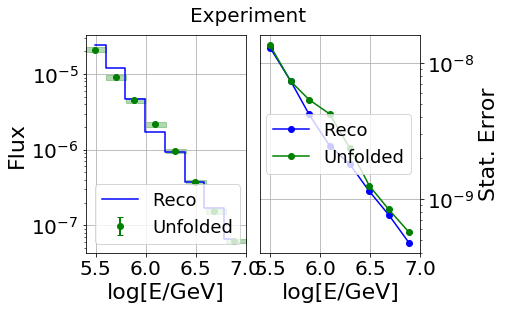

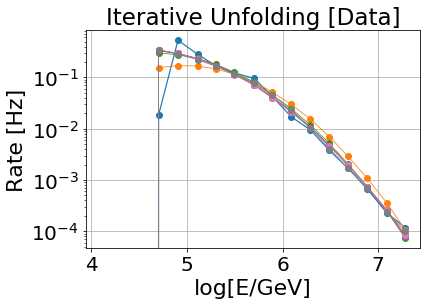

In [23]:
fig = plt.figure()
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:3, :2])
ax2 = plt.subplot(gs[:3, 2:4])

ax1.step(mid_logE[ene_mask], NEobs_flux[ene_mask], color='b', label='Reco', lw=1.5, where='mid')
ax1.errorbar(mid_logE[ene_mask], expflux[ene_mask], yerr=stat_experr[ene_mask], 
             color='g', label='Unfolded',
             elinewidth=2,
             capsize=3,
             ls='None', marker='.', ms=12, )

ax1.set_yscale('log')
ax1.set_xlabel('log[E/GeV]')
ax1.set_ylabel('Flux')
ax1.set_xticks(numpy.linspace(4.0,7.0,7))
ax1.set_xlim(5.4, 7.0)
ax1.legend()
for i in range(int(sum(ene_mask))):                                                                                                                                                    
    ax1.fill_between(STA2_loge[i:i+2], (STA2_flux-sys_experror[ene_mask])[i], 
                     (STA2_flux+sys_experror[ene_mask])[i], color='g', alpha=0.3) 

ax2.plot(mid_logE[ene_mask], NEobs_flux_err[ene_mask], 'bo-', 
         label='Reco', lw=1.5)
ax2.plot(mid_logE[ene_mask], stat_experr[ene_mask], 'go-', 
         label='Unfolded', lw=1.5)
ax2.set_xlabel('log[E/GeV]')
ax2.set_ylabel('Stat. Error')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax2.set_xticks(numpy.linspace(4.0,7.0,7))
ax2.set_yscale('log')
ax2.set_xlim(5.4, 7.0)
ax2.legend()
plt.suptitle('Experiment', fontsize=20)
if savefig:
    figname='unfolding_stat_error_comparison_exp_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

if return_iterations:
    plt.figure()
    #plt.plot(mid_logE, prior, label='Prior', marker='o', lw=1.2)
    plt.plot(mid_logE, NEobs_rate, label='Data Reco', marker='o', lw=1.2)
    for i in range(maxiter):
        plt.plot(mid_logE, unfolded_result['unfolded'][i], marker='o', 
                 label='Iter:%i'%(i+1), lw=0.8)
    #plt.legend()
    plt.yscale('log')
    #plt.xlim(5.4,7.0)
    plt.xlabel('log[E/GeV]')
    plt.ylabel('Rate [Hz]')
    plt.title('Iterative Unfolding [Data]')
    if savefig:
        figname='unfolding_iteration_spectrum_exp_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
        plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

    # ======Unfolding Matrix========
    if plot_unfolding:
        X,Y = numpy.meshgrid(loge_bins, loge_bins)
        for i in range(maxiter):
            plt.figure(figsize=(5,8))
            plt.pcolormesh(X, Y, unfolded_result['unfolding_matrix'][i], 
                           norm=LogNorm(), cmap='Spectral_r', vmin=1e-7, vmax=1e0)
            plt.xlabel('log[Etrue/GeV]')
            plt.ylabel('log[Ereco/GeV]')
            plt.grid()
            plt.colorbar()
            ax = plt.gca()
            ax.set_xticks(numpy.linspace(4.0,7.0,4))
            plt.title('Unfolding Matrix [Data, %i]'%(i+1))


Note: Systematics for HAWC might not be calculated properly. The one used here is sys_low and sys_high, and it ignores the sys_mc.

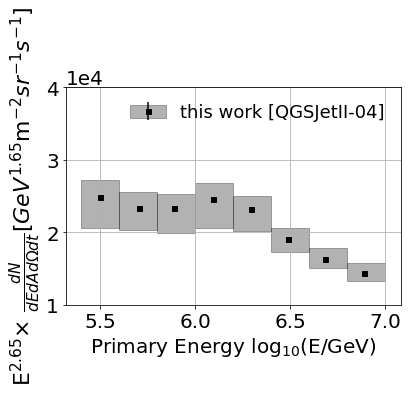

In [24]:
scale = 2.65

scale_factor_exp = scale_factor_func(scaleE_exp, scale)
scale_factor_3yr = scale_factor_func(scaleE_3yr, scale)
# ================== Scale 3yr Spectrum ====================
Flux           = H4a_Flux*scale_factor_3yr
Error_flux     = H4a_Flux_err*scale_factor_3yr
Syst_err_high  = Syst_high*scale_factor_3yr
Syst_err_low   = Syst_low*scale_factor_3yr

# ============== Flux with scaled energy spectrum ===========
if scale_unfolding:
    unfolded_energy_y = numpy.dot(scaledNEobs_rate,unfolding_matrix)

    expflux = cr_flux(unfolded_energy_y,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                  )
else:
    expflux = scale_factor_exp*expflux
stat_experr = scale_factor_exp*stat_experr

# ================ Make Scaled Flux easy to Read ====================
STA2_flux = expflux[ene_mask]
STA2_err  = stat_experr[ene_mask]
# ===Quadrature Sum of Systematics===
STA2_sys_low  = (scale_factor_exp[ene_mask])*STA2_sys_low
STA2_sys_high = (scale_factor_exp[ene_mask])*STA2_sys_high

# ============== Plot Data Scaled Flux after Unfolding ==============
plt.figure()
f1=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='s', markersize=5, label='2016 IT')
for i in range(int(sum(ene_mask))):
    f1f=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3)

if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

if plot_h4a:
    model_scaling_factor = scale_factor_func(10**model_bin, scale)
    model_h4a  = (model_scaling_factor*H4a(particle='all', E=10**model_bin))
    plt.plot(model_bin, model_h4a, 'r--', label='H4a', alpha=0.5)

plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)', fontsize=20)
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]',
               fontsize=22)
plt.ylim(1e4,4e4)
plt.legend([(f1,f1f)], ['this work [QGSJetII-04]'], loc='best', frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if savefig:
    figname='CR_flux_experiment_2016alone_scale%.2f_len%i_%s.png'%(scale,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')

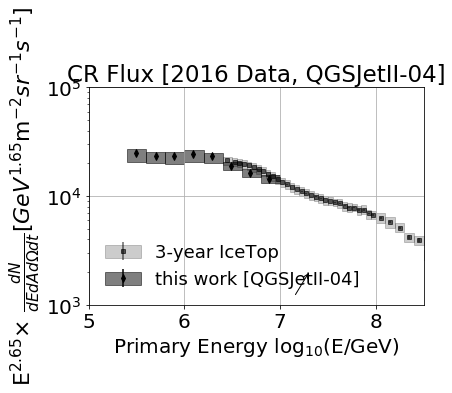

In [25]:
plt.figure()
f1=plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', alpha=0.6, fmt='s', markersize=4) #3 year IT                                                                                 
for i in range(len(H4a_E)):                                                                                                                                                    
    f1f=plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], color='k', alpha=0.2) 
f2=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', fmt='d', markersize=5)
for i in range(int(sum(ene_mask))):
    f2f=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5)
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

if plot_h4a:
    model_scaling_factor = scale_factor_func(10**model_bin, scale)
    model_h4a  = (model_scaling_factor*H4a(particle='all', E=10**model_bin))
    plt.plot(model_bin, model_h4a, 'r--', label='H4a', alpha=0.5)

ax = plt.gca()
ax.annotate('',
            xy=(7.15, 1200), xycoords='data',
            xytext=(15, 15*(scale-1)), textcoords='offset points',
            size=10,
            arrowprops=dict(arrowstyle="<-")
           )

plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)', fontsize=20)
plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]',
               fontsize=22)
plt.yscale('log')
plt.legend([(f1,f1f), (f2,f2f)], ['3-year IceTop','this work [QGSJetII-04]'], loc='lower left', frameon=False)
plt.xlim(5.0,8.5)
plt.ylim(1e3, 1e5)
plt.title('CR Flux [2016 Data, QGSJetII-04]')
if savefig:
    figname='CR_flux_experiment_scale%.2f_len%i_%s.png'%(scale,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')

if savehdf:
    hf = tables.open_file('flux_storage_temp%s.h5'%name, 'a')
    namemidE = 'STA2_midE_exp_%s_%s'%(which_scaling,which_prior)
    nameflux = 'STA2_flux_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    namestat = 'STA2_stat_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysL = 'STA2_sys_low_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysH = 'STA2_sys_high_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    if namemidE in hf.root:
        hf.remove_node('/', namemidE)
    if nameflux in hf.root:
        hf.remove_node('/', nameflux)
    if namestat in hf.root:
        hf.remove_node('/', namestat)
    if namesysL in hf.root:
        hf.remove_node('/', namesysL)
    if namesysH in hf.root:
        hf.remove_node('/', namesysH)
    hf.create_array('/', namemidE, STA2_midE)
    hf.create_array('/', nameflux, STA2_flux)
    hf.create_array('/', namestat, STA2_err)
    hf.create_array('/', namesysL, STA2_sys_low)
    hf.create_array('/', namesysH, STA2_sys_high)
    hf.close()
    

In [26]:
print list(STA2_flux)
print list(STA2_err)
print list(STA2_sys_low)
print list(STA2_sys_high)
print list(STA2_midE)


[24844.931527752164, 23310.31905031032, 23336.054304245194, 24546.924187878314, 23216.73775039811, 19125.53424061817, 16325.468034170857, 14385.83957745133]
[15.813428572090537, 18.82245502669529, 27.87482018368943, 47.5226263457365, 57.258918632615234, 63.92121545541668, 89.53236489259123, 131.5638829908253]
[4206.678750183216, 3004.665664830939, 3400.4141789392165, 3933.9844059632237, 3023.8556533790716, 1788.1203513524504, 1292.5105978127497, 1033.320816215697]
[2424.7092059232623, 2246.0184951040637, 2033.031242395604, 2207.8740543864888, 1876.9572688617195, 1521.0160127319903, 1526.9393998732708, 1368.2596060002845]
[5.497371082259108, 5.703164655708093, 5.888885058376492, 6.092112007140827, 6.292490217681279, 6.4899835923016775, 6.68429448077758, 6.8871139294310195]


NameError: name 'scaledNEobs_flux' is not defined

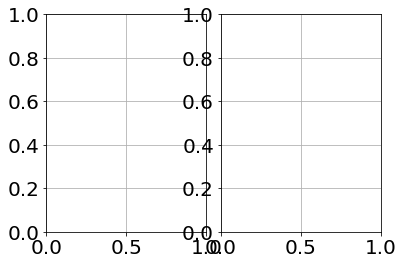

In [27]:
if True:
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[:3, :2])
    ax2 = plt.subplot(gs[:3, 2:4])

    ax1.step(mid_logE[ene_mask], scaledNEobs_flux[ene_mask], color='b', label='Reco', lw=1.5, where='mid')
    ax1.errorbar(mid_logE[ene_mask], expflux[ene_mask], yerr=stat_experr[ene_mask], 
                 color='g', label='Unfolded',
                 elinewidth=2,
                 capsize=3,
                 ls='None', marker='.', ms=10, )
    #ax1.set_yscale('log')
    ax1.set_xlabel('log[E/GeV]')
    ax1.set_ylabel('Flux')
    ax1.set_xticks(numpy.linspace(4.0,7.0,7))
    ax1.set_xlim(5.4, 7.0)
    ax1.legend(loc='best')
    for i in range(int(sum(ene_mask))):                                                                                                                                                    
        ax1.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='g', alpha=0.3) 

    ax2.plot(mid_logE[ene_mask], scaledNEobs_flux_err[ene_mask], 'bo-', 
             label='Reco', lw=1.5)
    ax2.plot(mid_logE[ene_mask], stat_experr[ene_mask], 'go-', 
             label='Unfolded', lw=1.5)
    ax2.set_xlabel('log[E/GeV]')
    ax2.set_ylabel('Stat. Error')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.set_ticks_position("right")
    ax2.set_xticks(numpy.linspace(4.0,7.0,7))
    #ax2.set_yscale('log')
    ax2.set_xlim(5.4, 7.0)
    ax2.legend(loc='best')
    plt.suptitle('Exp [scale=%.2f]'%scale, fontsize=20)